In [1]:
from readTextMustai import GetTextRead, TexttoTable
import pandas as pd
import pyautogui
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import psutil

In [2]:
def calculate_center(row):
    x_coords = [point[0] for point in row]
    y_coords = [point[1] for point in row]

    center_x = sum(x_coords) / 4
    center_y = sum(y_coords) / 4

    return (center_x, center_y)

In [3]:
found_processes = []
# Get all processes that contain the given name
for proc in psutil.process_iter(['pid', 'name']):
    if "Ansys".lower() in proc.info['name'].lower():
        found_processes.append(proc)

In [4]:
found_processes

[]

In [5]:
# Define the function outside of the class
import time
def wait_for_cpu_drop(process_name_contains, spike_threshold=15, drop_threshold=5, max_wait_for_spike=20):
    found_processes = []
    # Get all processes that contain the given name
    for proc in psutil.process_iter(['pid', 'name']):
        if process_name_contains.lower() in proc.info['name'].lower():
            found_processes.append(proc)

    if not found_processes:
        # If no processes are found, you can handle it accordingly
        raise ProcessLookupError(f"No process containing {process_name_contains} found.")

    for process in found_processes:
        time_start = time.time()
        spike_detected = False

        # Wait for 2 seconds, checking for a CPU usage spike
        while (time.time() - time_start) < max_wait_for_spike:
            cpu_usage = process.cpu_percent(interval=0.1)  # Check every 0.1 seconds
            if cpu_usage > spike_threshold:
                spike_detected = True
                break
        
        # If a spike was detected, wait until it drops below drop_threshold
        if spike_detected:
            while cpu_usage > drop_threshold:
                cpu_usage = process.cpu_percent(interval=0.1)

In [7]:
# wait_for_cpu_drop('Ansys')

In [8]:
class mustaiControl:
    def __init__(self, ansys_todo):
        """
        Args:
            ansys_todo (series): (Button, Command, Pause)
        """
        self.ansys_todo = ansys_todo
        self.df_screenshot = None
        self.df_mousecontrol = None
        self.exact_matches = None 
    
    def screen_capture(self):
        # Capture the screen with PyAutoGUI
        import pyautogui
        screenshot = pyautogui.screenshot()
        screenshot.save('screenshot.png')
    
    def image_to_text(self):
        GetTextRead(image_file='screenshot.png', outputfile=f'{self.ansys_todo.Command}')
            
    def text_to_table(self):
        df_screenshot = TexttoTable(f'{self.ansys_todo.Command}.txt')
        df_screenshot[['leftTop', 'rightTop', 'rightBottom', 'leftBottom']] = pd.DataFrame(df_screenshot['Coordinates'].tolist(), index=df_screenshot.index)
        # Compute the center position
        df_screenshot['MousePosition'] = df_screenshot[['leftTop', 'rightTop', 'rightBottom', 'leftBottom']].apply(lambda row: calculate_center(row), axis=1)
        self.df_screenshot = df_screenshot
        
    def mouse_control(self):

        # Check for exact matches
        exact_matches = self.df_screenshot[self.df_screenshot['Name'].str.lower() == self.ansys_todo.Button.lower()]

        if not exact_matches.empty:
            # If there are exact matches, use them
            self.exact_matches = exact_matches
            self.df_mousecontrol = exact_matches.copy()
        else:
            # If there are no exact matches, use contains
            self.df_mousecontrol = self.df_screenshot[self.df_screenshot.Name.str.contains(self.ansys_todo.Button, case=False, na=False)].copy()
      
        
        self.df_mousecontrol["Command"] = self.ansys_todo.Command
        
        x_coord = self.df_mousecontrol['MousePosition'].iloc[0][0]
        y_coord = self.df_mousecontrol['MousePosition'].iloc[0][1]
        
        command = self.ansys_todo.Command
        if command.lower() == "click":
            pyautogui.click(x=x_coord, y=y_coord)
        
        elif command.lower() == "doubleclick":
            pyautogui.doubleClick(x=x_coord, y=y_coord)
            pyautogui.sleep(5)
            wait_for_cpu_drop('AnsysWBU.exe')
            pyautogui.sleep(5)
            
        elif command.lower() == "rightclick":
            pyautogui.rightClick(x=x_coord, y=y_coord)
            
        elif command.lower() == "enter":
            pyautogui.press("enter")
        
        elif command.lower() == "move":
            pyautogui.moveTo(x_coord, y_coord)                
        
        # Common actions after executing the command
        pyautogui.sleep(0.5)
        # self.display_screenshot()
    
    def display_screenshot(self):
        screenshot = pyautogui.screenshot()
        plt.figure(figsize=(18, 12))  # You can adjust the size as needed
        plt.axis('off')
        plt.imshow(screenshot)
        plt.show()     
            
    def run(self):
        self.screen_capture()
        self.image_to_text()
        self.text_to_table()
        self.mouse_control()
        

Step 1 completed: Model - doubleClick
Step 2 completed: Contex - rightClick
Step 3 completed: Maximise - click
Step 4 completed: Home - click
Step 5 completed: Full - click
Step 6 completed: Solution - rightClick
Step 7 completed: Insert - move
Step 8 completed: stres - move
Step 9 completed: von-Mises - click
Step 10 completed: Equivalent Stress - rightClick


IndexError: single positional indexer is out-of-bounds

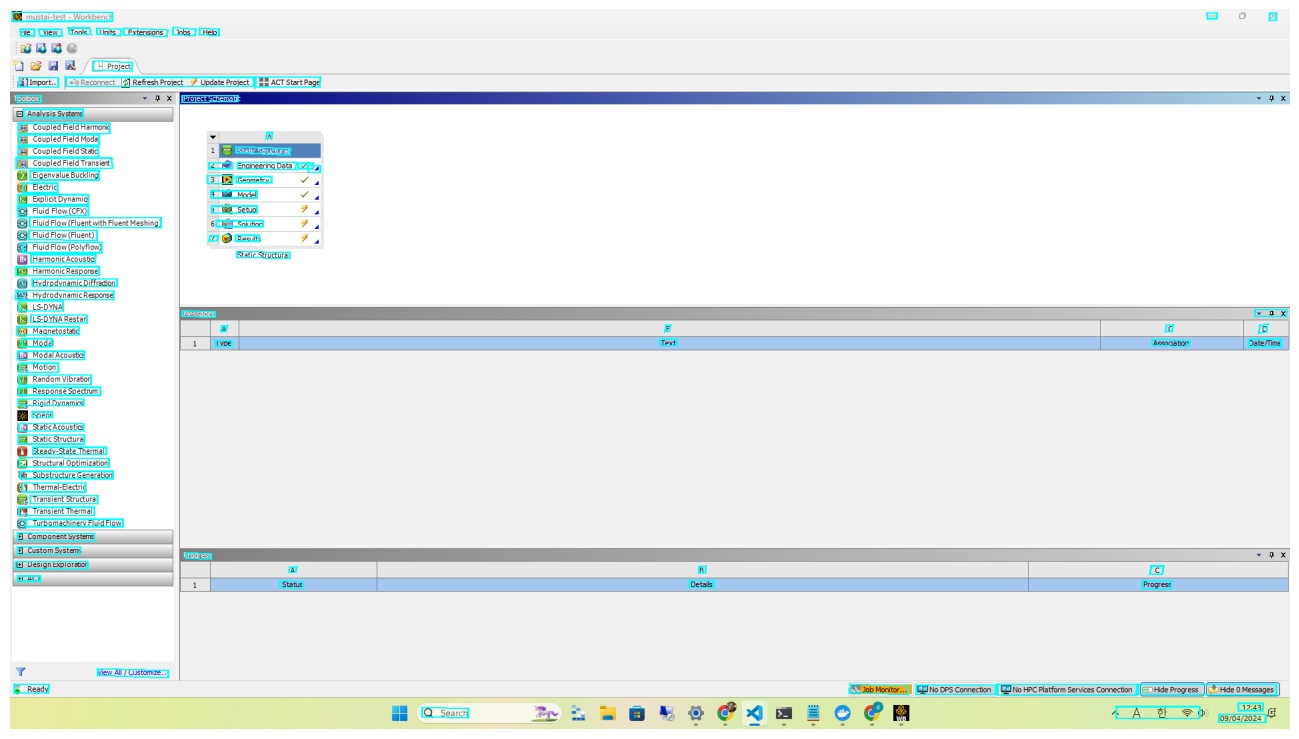

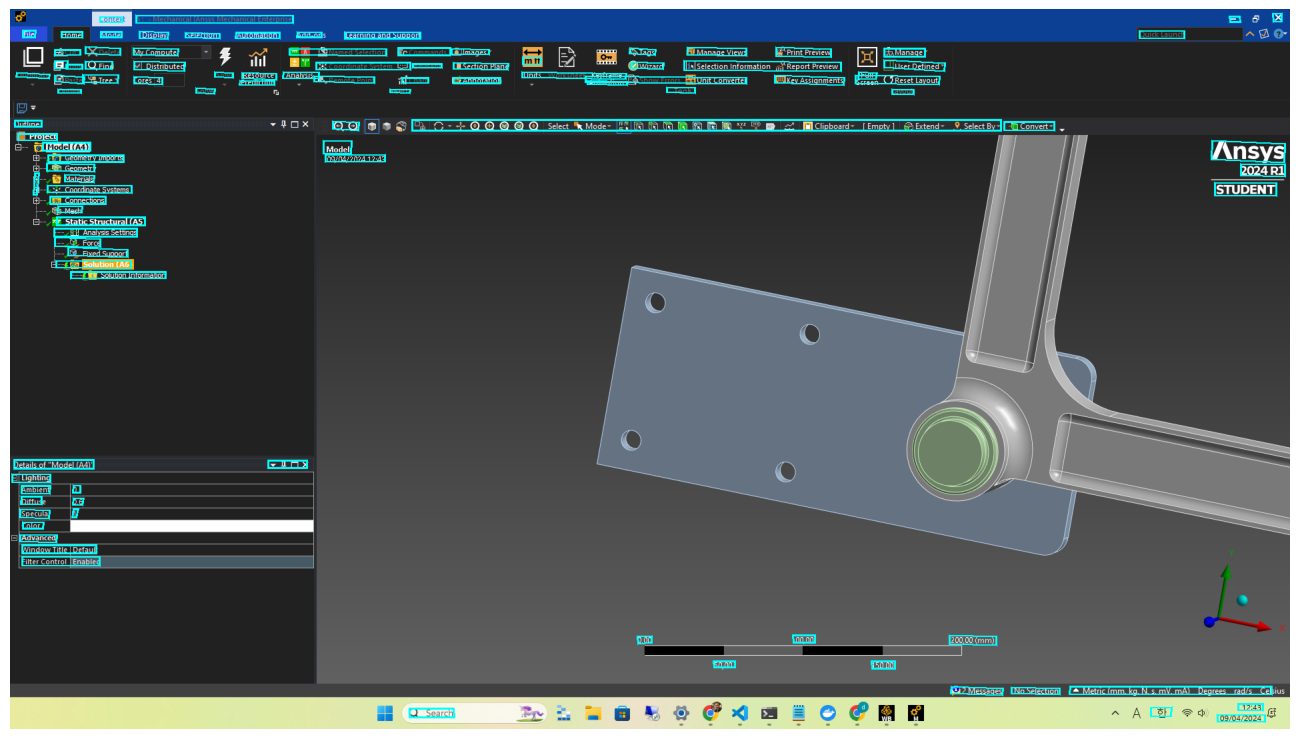

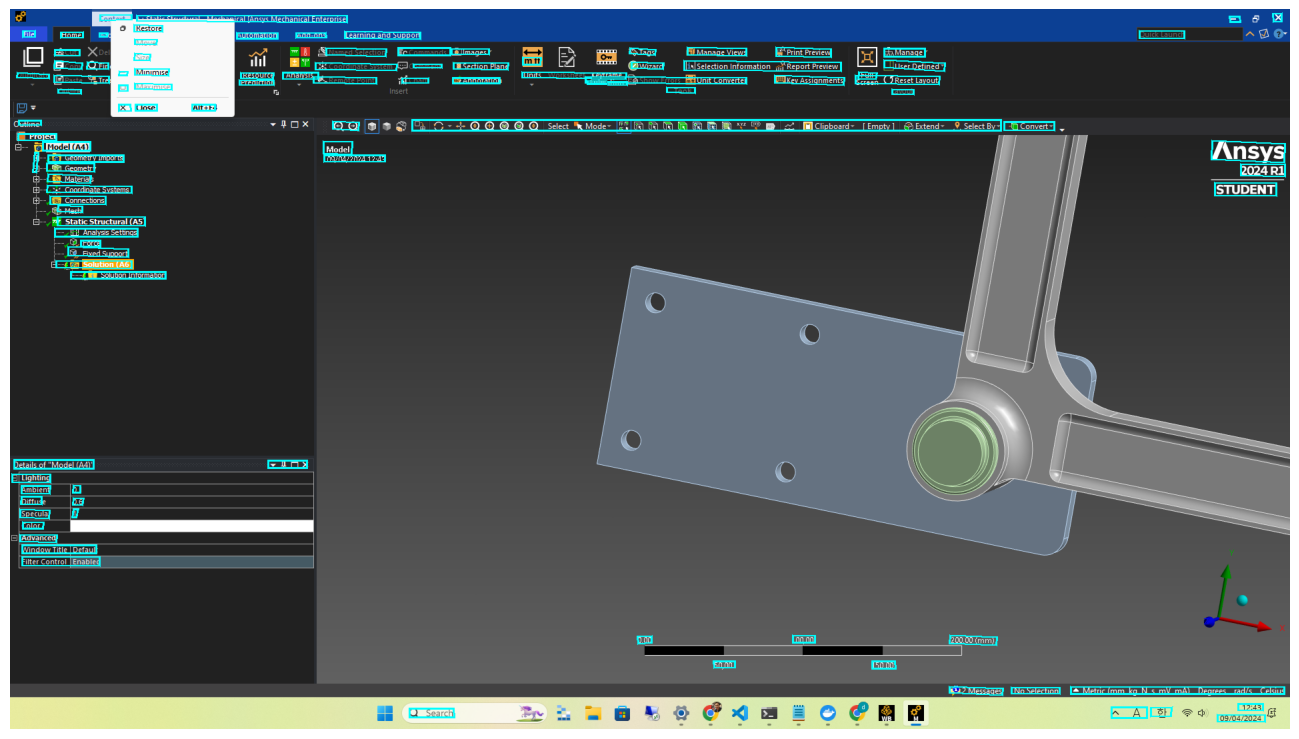

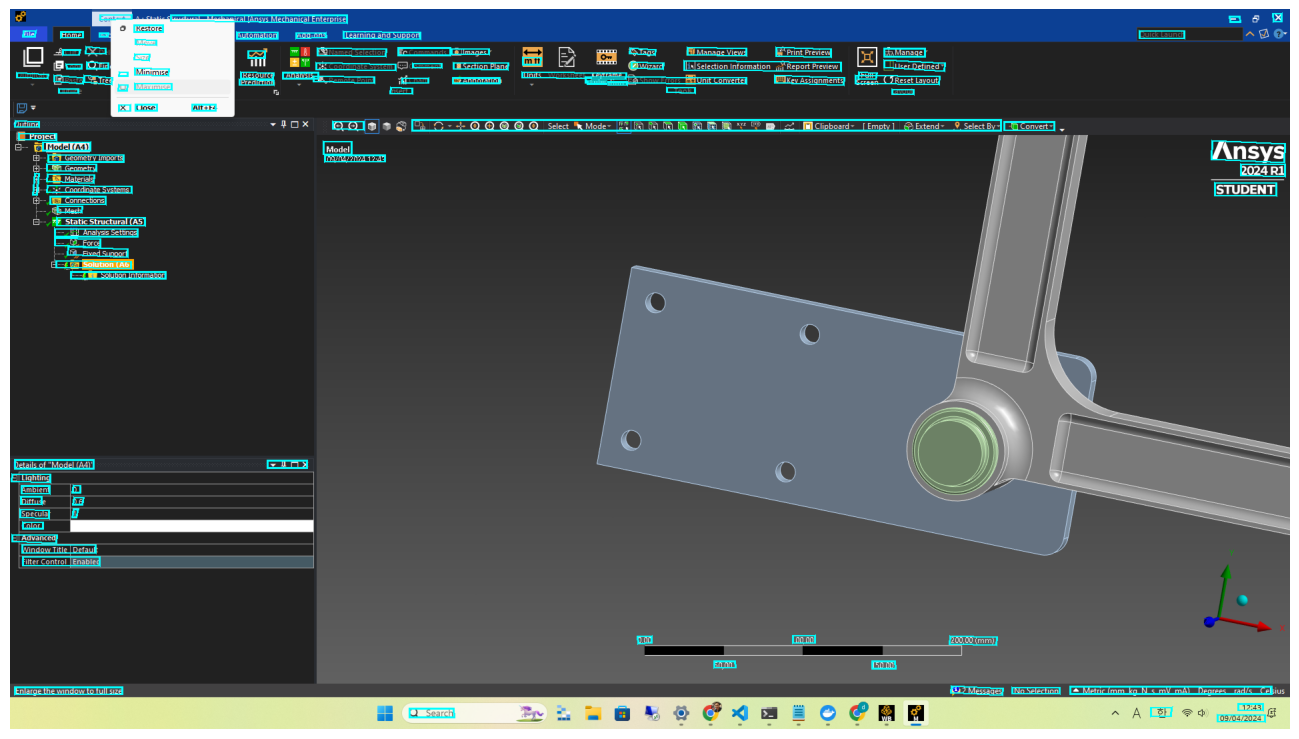

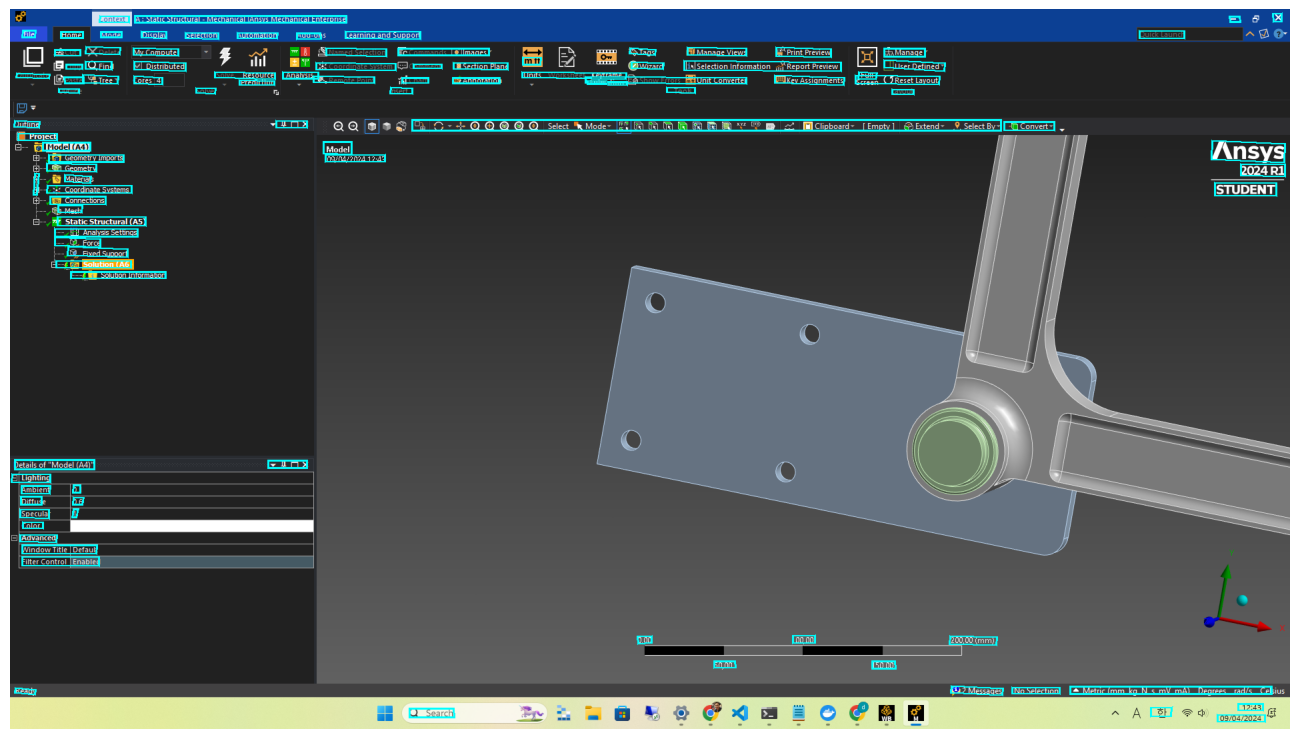

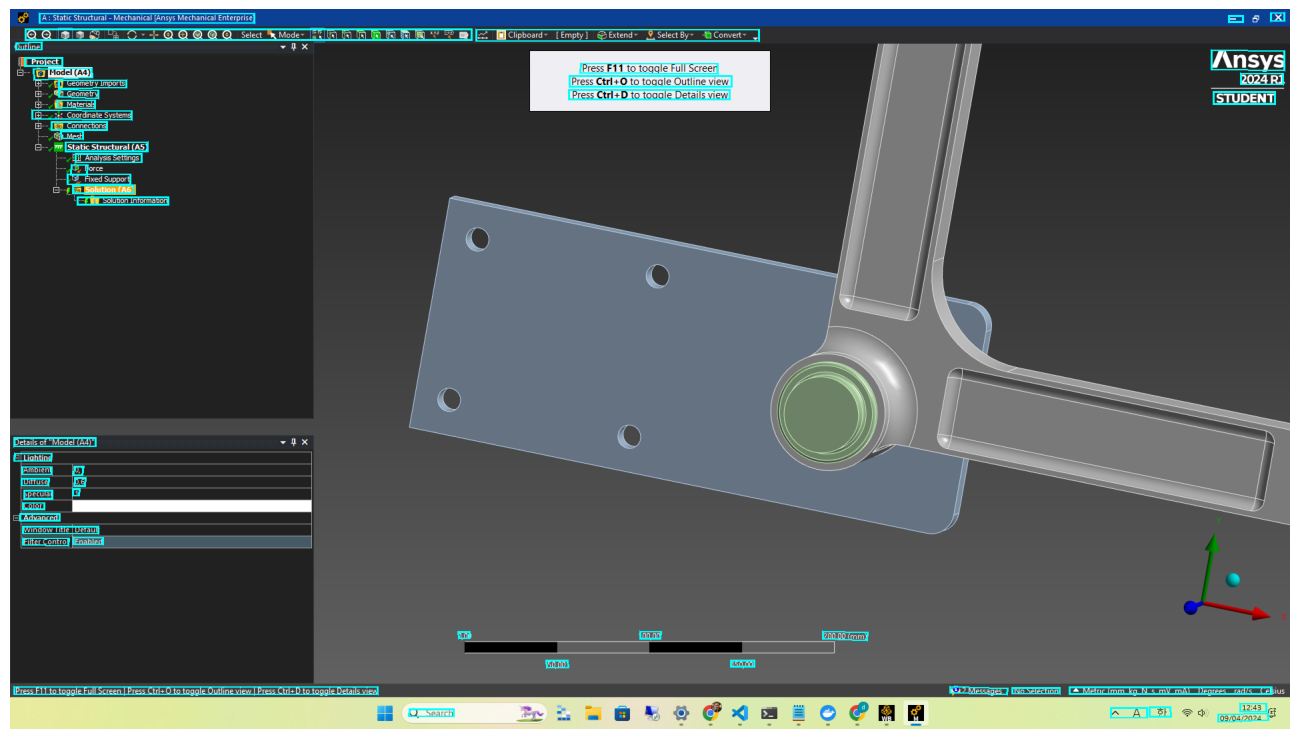

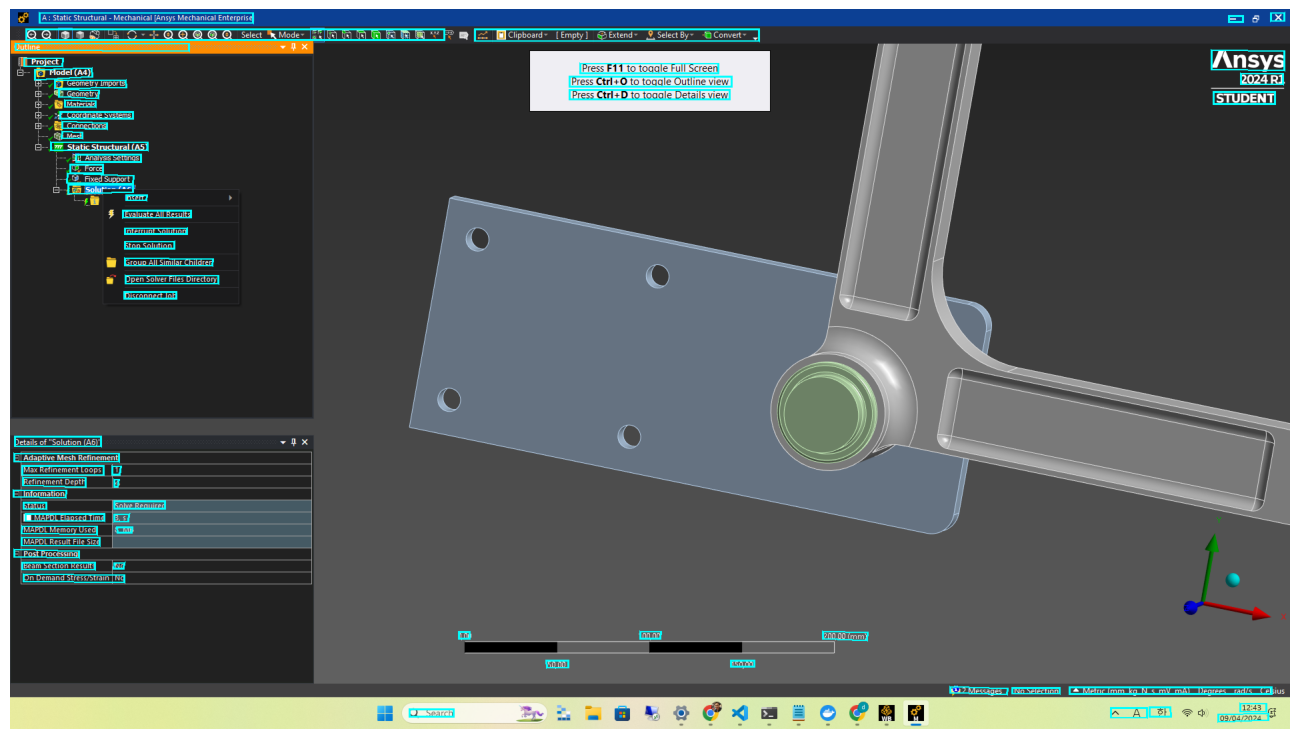

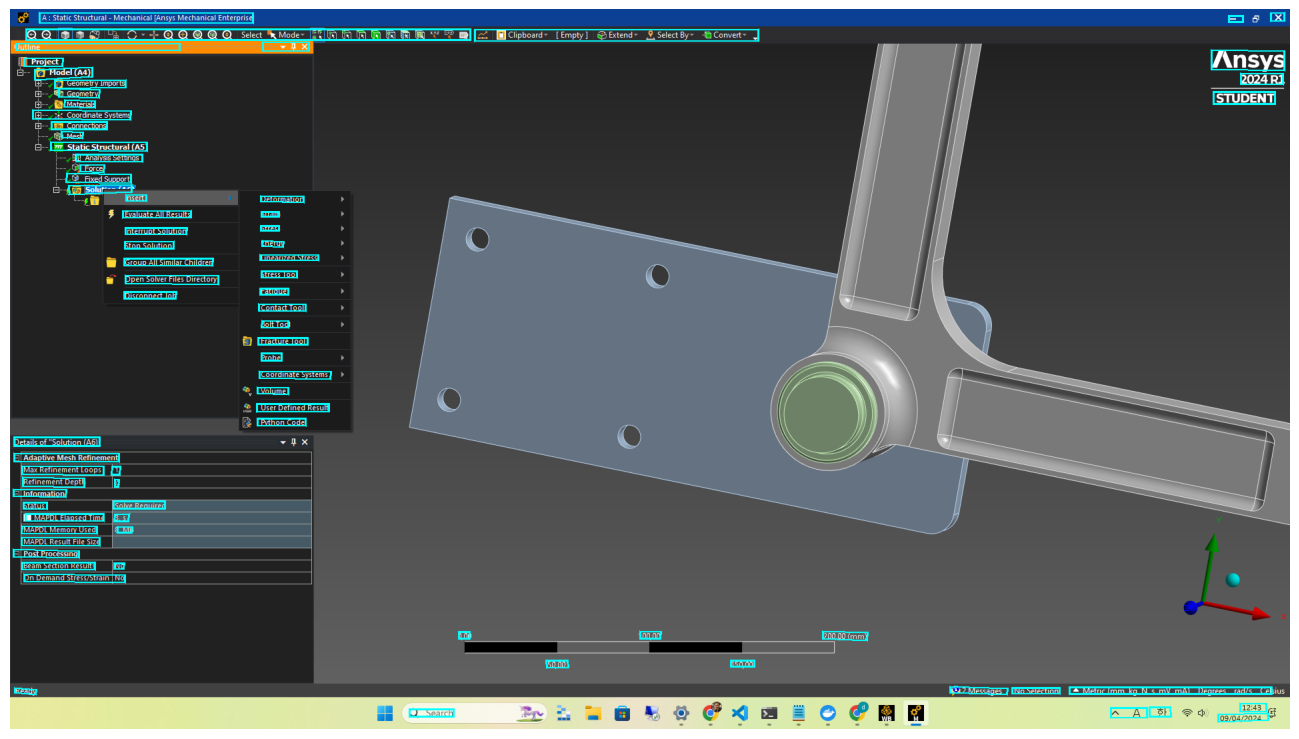

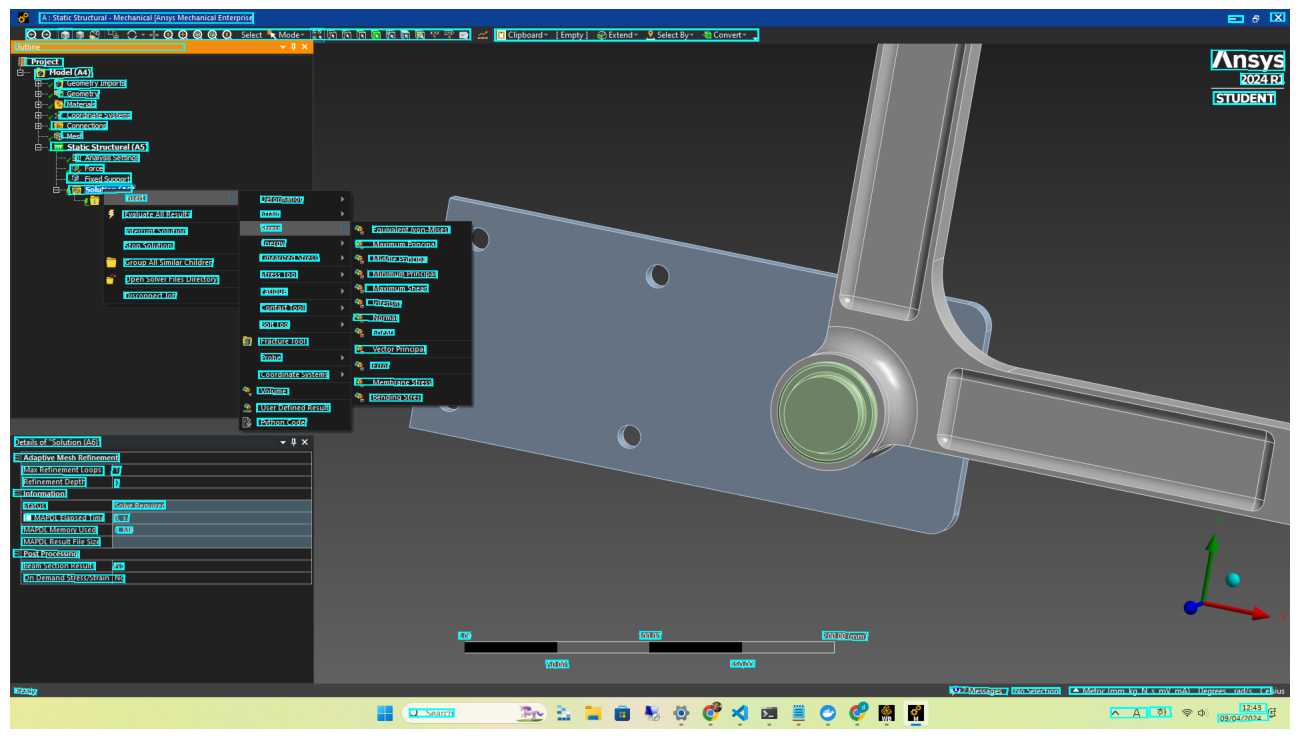

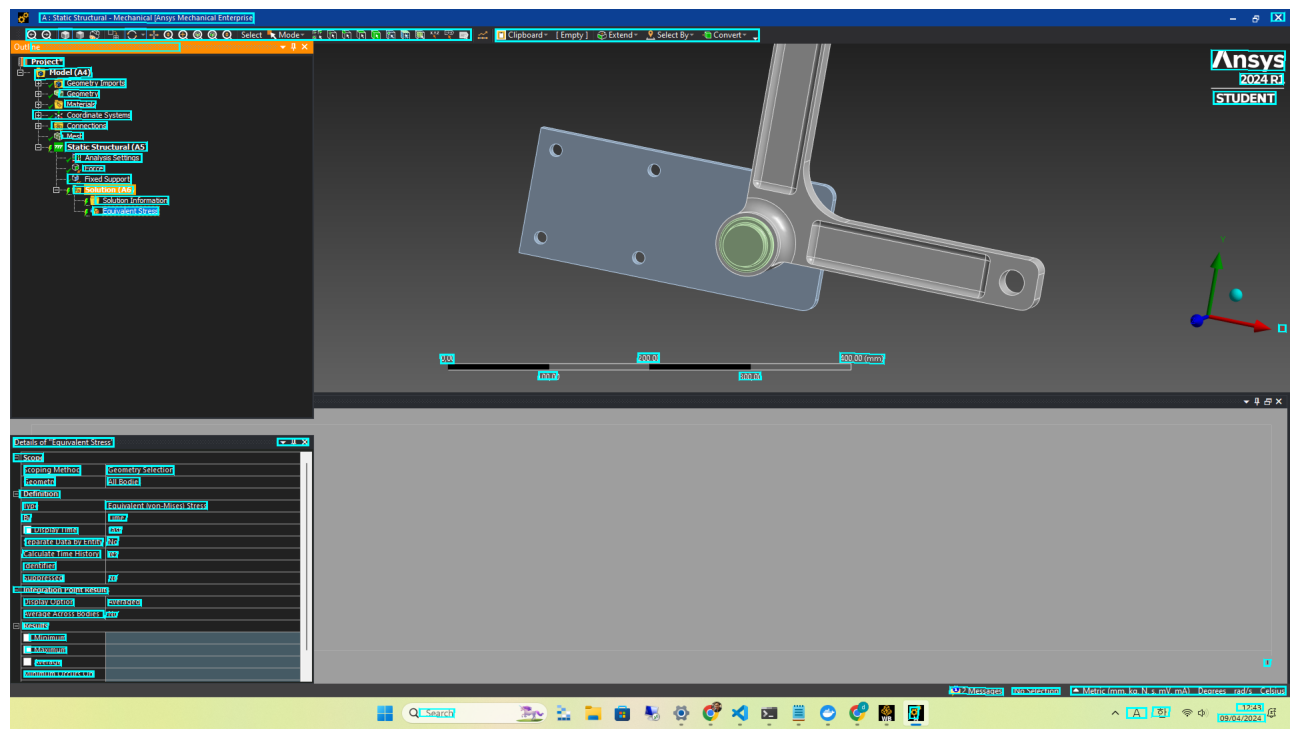

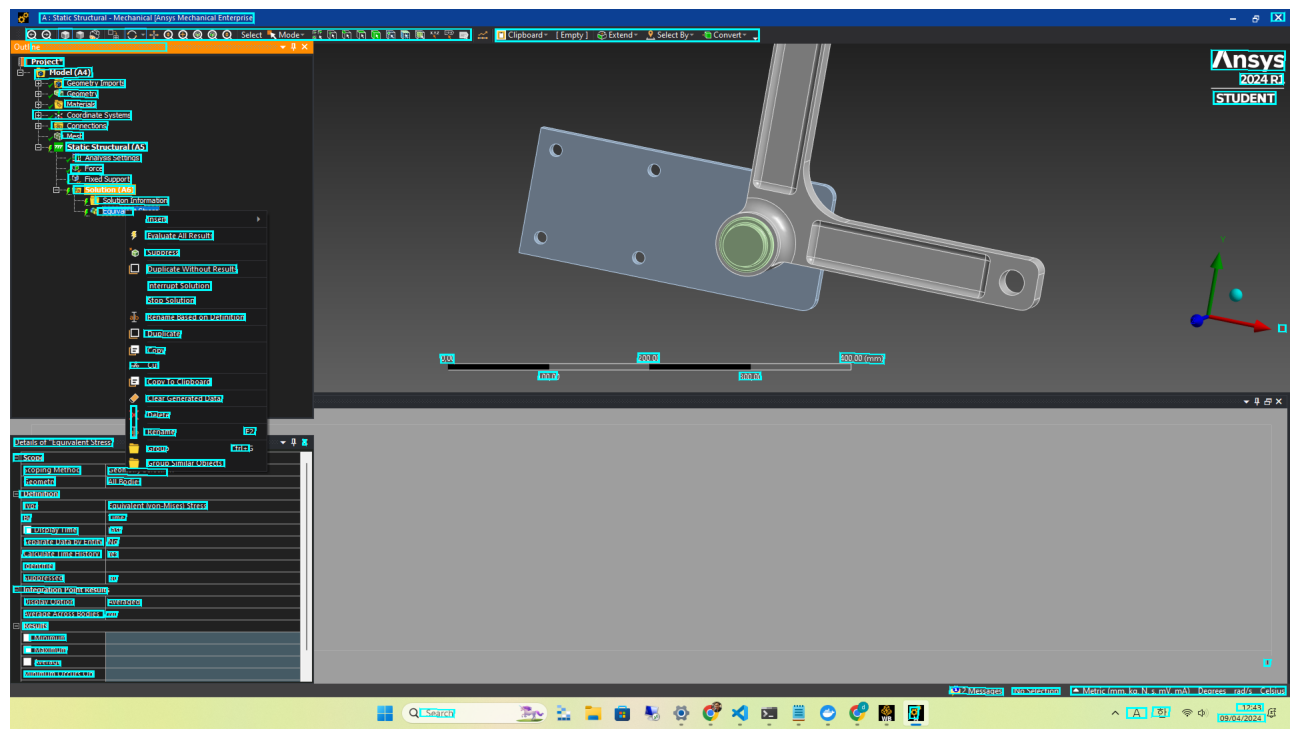

In [21]:
df_process = pd.read_csv('../process/process_structural.csv').reset_index(drop=True).set_index("Step")
for i, row in df_process.iterrows():
    mustaiControl_obj = mustaiControl(ansys_todo=row)
    mustaiControl_obj.run()
    print(f"Step {i} completed: {mustaiControl_obj.ansys_todo.Button} - {mustaiControl_obj.ansys_todo.Command}")
    if i == len(df_process):
        time.sleep(7)
        mustaiControl_obj.display_screenshot()